# 2 - Internal Validation with Complete Data

This Jupyter notebook contains the code to load the models obtained in the generation step, calculate performance measures on the entire IMC dataset which was used for training. It also calculates the sensitivity/specificity for different classification threhsolds from 0 to 1.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import dateutil.parser

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from scipy import interp
from scipy.interpolate import interp1d

%matplotlib inline

This notebook evaluates different models and gives the minimum and maximum contribution from each term

In [2]:
# %load import_notebook.py
# Infraestructure to import a Jupyter notebook
# http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Importing%20Notebooks.html

import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
        

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.cells:
                if cell.cell_type == 'code':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.source)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod
    
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

sys.meta_path.append(NotebookFinder())

In [3]:
from LogRegUtils import LogRegModel
from LogRegUtils import caldis, calibration_table, calibration, calibration2
from LogRegUtils import create_plots

importing Jupyter notebook from LogRegUtils.ipynb


In [4]:
# Some utilities

def validation(ytrue, probs, thres):
    ypred = [int(thres < p) for p in probs]

    auc = roc_auc_score(ytrue, probs)
    brier = brier_score_loss(ytrue, probs)
    cal, dis = caldis(ytrue, probs)
    acc = accuracy_score(ytrue, ypred)
    precision, recall, f1score, support = precision_recall_fscore_support(ytrue, ypred)

    P = N = 0
    TP = TN = 0
    for i in range(len(ytrue)):
        if ytrue[i] == 1:
            P += 1
            if ypred[i] == 1: TP += 1
        else:
            N += 1
            if ypred[i] == 0: TN += 1

    sens = float(TP)/P            
    spec = float(TN)/N

    cfr = 100 * (float(np.sum(ytrue)) / len(ytrue))
    
    print("Number of cases :", len(ytrue)) 
    print("Number of deaths:", np.sum(ytrue)) 
    print("CFR             : %0.2f" % cfr)

    print("") 
    print("Measures of performance") 
    print("AUC           : %0.2f" % auc) 
    print("Brier         : %0.2f" % brier) 
    print("Calibration   : %0.2f" % cal) 
    print("Discrimination: %0.2f" % dis) 
    print("Accuracy      : %0.2f" % acc) 
    print("Sensitivity   : %0.2f" % sens) 
    print("Specificity   : %0.2f" % spec) 

In [5]:
sel_model = 3

risk_threshold = 0.5

make_plots = False

data_file = 'data_normalized.csv'
data_ct_file = 'data_ct_normalized.csv'

# Parameters for normalized data
rt_var = 'reftime'
ct_mean = 0
ct_low = -1

sl_only = False
lb_only = False

if sel_model == 1:
    model_name = 'all-minimal'
elif sel_model == 2:
    model_name = 'all-clinical-only'
elif sel_model == 3:
    model_name = 'all-parsimonious'
elif sel_model == 4:
    model_name = 'all-parsimonious-notemp'    
elif sel_model == 5:    
    model_name = 'sl-wellness-parsimonious'
    sl_only = True
elif sel_model == 6:    
    model_name = 'sl-wellness-parsimonious-notemp'
    sl_only = True    
elif sel_model == 7:
    model_name = 'sl-wellness-clinical-only'
    sl_only = True    
elif sel_model == 8:
    model_name = 'sl-wellness-minimal'
    sl_only = True
elif sel_model == 9:
    model_name = 'sl-parsimonious'
    sl_only = True
    data_file = 'data.csv'
    data_ct_file = 'data_ct.csv'
    rt_var = 'DaysSinceSymptomFeverOnset'
    ct_mean = 25
    ct_low = 20

In [6]:
# Load data, model, generate test dataset, save minmax ranges for coefficients and odd-ratios
imc_data_folder = '../data'

imc_data_file = os.path.join(imc_data_folder, data_file)

# Use this when generating params for lb-parsimonious model
# imc_data_file = os.path.join(imc_data_folder, 'data.csv')

imc_dict_file = os.path.join(imc_data_folder, 'dictionary.csv')
imc_data = pd.read_csv(imc_data_file, na_values="\\N")

if sl_only:
    imc_data = imc_data[(imc_data['ETUKey'] == 2) | (imc_data['ETUKey'] == 4) | (imc_data['ETUKey'] == 5)]    
if lb_only:
    imc_data = imc_data[(imc_data['ETUKey'] == 1) | (imc_data['ETUKey'] == 3)]

model_params = os.path.join(model_name, 'model.csv')
model_ranges= os.path.join(model_name, 'ranges.txt')
model_oddratios = os.path.join(model_name, 'oddratios.txt')
model_riskratios = os.path.join(model_name, 'riskratios.txt')

model = LogRegModel(model_params)

variables = ['Disposition'] + model.names

print(variables)

test_data = imc_data[variables].dropna()
x = test_data[test_data.columns[1:]].values

['Disposition', 'PatientAge', 'cycletime', 'FeverTemperature', 'Jaundice', 'Bleeding', 'Breathlessness', 'SwallowingProblems', 'reftime']


8.14656 - 0.0589 PatientAge + 4e-05 max(PatientAge - 5.0, 0)^3 - 7e-05 max(PatientAge - 30.0, 0)^3 + 3e-05 max(PatientAge - 58.0, 0)^3 - 0.69197 cycletime - 0.20566 FeverTemperature + 0.08365 max(FeverTemperature - 36.3, 0)^3 - 0.11933 max(FeverTemperature - 37.2, 0)^3 + 0.03568 max(FeverTemperature - 39.31, 0)^3 + 1.33912 Jaundice + 1.02004 Bleeding + 0.17193 Breathlessness + 0.14673 SwallowingProblems + 0.0012 reftime - 0.04206 cycletime * reftime


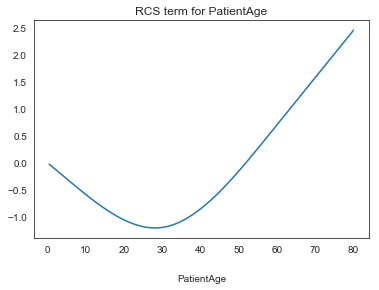

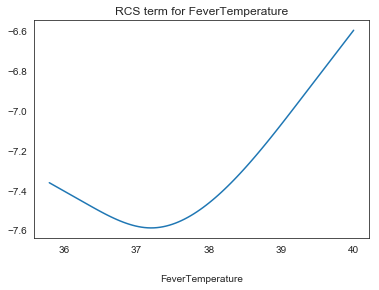

In [7]:
model.saveRanges(x, model_ranges)
model.loadVarTypes(imc_data_file, imc_dict_file)
model.saveOddRatios(x, model_oddratios)
model.saveRiskRatios(x, model_riskratios)

model.plotRCSTerms(x, model_name)
print(model.getFormula(5))

In [52]:
# DISREGARD THESE RESULTS, NOT SURE HOW TO CALCULATE RISK RATIOS FOR VARIABLES INVOLVED IN INTERACTION TERMS.

# Interpretation of odds ratios in logistic regression models:
# https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/

# Risk Ratios for different values of referral time (the riskratios.txt only contains the RRs corresponding to
# a change over the median)
# For a percentage interpretation, see the following:
# http://sphweb.bumc.bu.edu/otlt/MPH-Modules/EP/EP713_Association/EP713_Association3.html
# So, when RR > 1, (RR -1 x 100) can be seen the percentual increment in risk compared with the 
# "non-exposed" group. In this case, non-exposed means presenting below the given referral time threshold

if rt_var in variables:
#     msg = 'RR of presenting %i days after symptom onset: %0.2f'
#     for day in range(1, 10):
#         rr = model.getRiskRatios(x, intd = day)[rt_var]
#         print(msg % (day, rr))
        
    coeffs = model.getCoefficients()
    ct = ct_low
    ct_data = test_data[test_data['cycletime'] < ct_mean]
    for day in range(1, 10):
        msg = 'RR of presenting %i days after symptom onset: %0.2f'
        l1 = len(ct_data[ct_data[rt_var] <= day]) 
        m1 = len(ct_data[ct_data[rt_var] > day]) 
        p0 = l1 / (l1 + m1)
        odds = np.exp(coeffs[rt_var] + coeffs['cycletime * ' + rt_var] * ct)
        rr = odds/((1-p0)+p0*odds)
        print(msg % (day, rr))
        

#     dat = test_data
#     dat = test_data[test_data['cycletime'] < ct_mean]
#     dat = test_data[test_data['cycletime'] < ct_mean - 1]
    
#     day = 3
#     early_data = dat[dat[rt_var] <= day]
#     late_data = dat[dat[rt_var] > day]    
    
#     x0 = early_data[early_data.columns[1:]].values
#     x1 = late_data[late_data.columns[1:]].values
    
#     p0 = model.predict(x0)
#     p1 = model.predict(x1)    
    
#     print(p1.mean()/p0.mean())
#     print(p1.mean())
        

RR of presenting 1 days after symptom onset: 1.03
RR of presenting 2 days after symptom onset: 1.03
RR of presenting 3 days after symptom onset: 1.02
RR of presenting 4 days after symptom onset: 1.01
RR of presenting 5 days after symptom onset: 1.01
RR of presenting 6 days after symptom onset: 1.01
RR of presenting 7 days after symptom onset: 1.00
RR of presenting 8 days after symptom onset: 1.00
RR of presenting 9 days after symptom onset: 1.00
1.0024017701924388


## Performance measures for a fixed risk threshold

The following cells calculates a number of performance measures using the fixed risk (classification) threshold set in the risk_threshold variable, and the AUC and calibration curves.

In [9]:
ytrue = [int(v) for v in test_data[test_data.columns[0]].values]
probs = model.predict(x)
ypred = [int(risk_threshold < p) for p in probs]
validation(ytrue, probs, risk_threshold)

Number of cases : 89
Number of deaths: 57
CFR             : 64.04

Measures of performance
AUC           : 0.87
Brier         : 0.15
Calibration   : 0.02
Discrimination: 0.11
Accuracy      : 0.82
Sensitivity   : 0.88
Specificity   : 0.72


In [10]:
if make_plots:
    # ROC plot
    fpr, tpr, thresholds = roc_curve(ytrue, probs)
    fig, ax = plt.subplots()
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.plot([0, 1], [0, 1], 'k--', c='grey')
    plt.plot(fpr, tpr, color='black')
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    fig.savefig(os.path.join(model_name, 'internal-roc-complete.pdf'))

    # Calibration plot
    cal_table = calibration_table(ytrue, probs, 10)
    fig, ax = plt.subplots()
    plt.plot([0.05, 0.95], [0.05, 0.95], '-', c='grey', linewidth=0.5, zorder=1)
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.xlabel('Predicted Risk')
    plt.ylabel('Observed Risk')
    x = cal_table['pred_prob']
    y = cal_table['true_prob']
    # f = interp1d(x, y, kind='cubic')
    # xnew = np.linspace(min(x), max(x), num=50, endpoint=True)    
    # plt.plot(xnew, f(xnew))
    plt.plot(x, y, color='black')
    fig.savefig(os.path.join(model_name, 'internal-cal-complete.pdf'))

## Sensitivity/specificity for an entire range of thresholds

The following code evaluates sensitivity and specificity across a range of risk/classification thresholds from 0 to 1, and saves them into a table inside the model folder.

In [11]:
ncells = 20
thresholds = np.linspace(0.0,  1.0,  ncells + 1)
ytrue = [int(v) for v in test_data[test_data.columns[0]].values]
x = test_data[test_data.columns[1:]].values

interval = []
sensitivity = []
specificity = []
surv_count = []
died_count = []
for t in thresholds[:-1]:
    probs = model.predict(x)
    ypred = [int(t < p) for p in probs]
    t1 = t + 1.0/ncells
    
    in_cell = [t < p and p <= t1 for p in probs]
    
    nsurv = 0
    ndied = 0    
    P = N = 0
    TP = TN = 0
    for i in range(len(ytrue)):
        if ytrue[i] == 1:            
            P += 1
            if ypred[i] == 1: TP += 1
            if in_cell[i]: ndied += 1
        else:
            N += 1
            if ypred[i] == 0: TN += 1
            if in_cell[i]: nsurv += 1    
            
    sens = float(TP)/P            
    spec = float(TN)/N
    
    interval.append('{0:.2f}'.format(t) + "-" + '{0:.2f}'.format(t1))
    sensitivity.append(sens)
    specificity.append(spec)
    surv_count.append(nsurv)
    died_count.append(ndied)
    
df = pd.DataFrame({'Threshold':pd.Series(np.array(interval)), 
                   'Sensitivity':pd.Series(np.array(sensitivity)),
                   'Specificity':pd.Series(np.array(specificity)),
                   'Survival':pd.Series(np.array(surv_count)),
                   'Mortality':pd.Series(np.array(died_count))}, 
                   columns=['Threshold', 'Sensitivity', 'Specificity', 
                            'Survival', 'Mortality'])

df.to_csv(os.path.join(model_name, 'sensitivity-specificity.csv'))    
df

,Threshold,Sensitivity,Specificity,Survival,Mortality
0,0.00-0.05,1.000000,0.00000,1,0
1,0.05-0.10,1.000000,0.03125,2,0
2,0.10-0.15,1.000000,0.09375,0,1
3,0.15-0.20,0.982456,0.09375,1,1
4,0.20-0.25,0.964912,0.12500,3,1
5,0.25-0.30,0.947368,0.21875,4,0
6,0.30-0.35,0.947368,0.34375,4,1
7,0.35-0.40,0.929825,0.46875,2,2
8,0.40-0.45,0.894737,0.53125,5,1
9,0.45-0.50,0.877193,0.68750,1,0


## Performance comparison using day 1 and day 2 CT

In [12]:
ct_data_file = os.path.join(imc_data_folder, data_ct_file)
ct_data = pd.read_csv(ct_data_file, na_values="\\N")

print(ct_data)

ct_data['SpecimenCollectionDate1'] = pd.to_datetime(ct_data['SpecimenCollectionDate1'])
ct_data['SpecimenCollectionDate2'] = pd.to_datetime(ct_data['SpecimenCollectionDate2'])

ct1_data = ct_data.drop(columns=['cycletime'])
ct1_data.rename(columns={'cycletime1':'cycletime'}, inplace=True)
test1_data = ct1_data[variables].dropna()
x1 = test1_data[test1_data.columns[1:]].values

diff2 = pd.Timedelta(days=2)
ct2_data = ct_data[ct_data['SpecimenCollectionDate2'] - ct_data['SpecimenCollectionDate1'] <= diff2]
ct2_data = ct2_data.drop(columns=['cycletime'])
ct2_data.rename(columns={'cycletime2':'cycletime'}, inplace=True)
test2_data = ct2_data[variables].dropna()
x2 = test2_data[test2_data.columns[1:]].values

     PatientKey  ETUKey  PatientAge  PatientSex  Disposition  Fever  \
0         24049       2       52.00         1.0          0.0    0.0   
1         24051       2       13.00         1.0          0.0    1.0   
2         24054       2       35.00         0.0          1.0    1.0   
3         24061       2       53.00         1.0          1.0    1.0   
4         24064       2       12.00         1.0          1.0    1.0   
5         24065       2       14.00         0.0          1.0    1.0   
6         24067       2        1.00         0.0          1.0    1.0   
7         24072       2       45.00         0.0          1.0    0.0   
8         24073       2       50.00         0.0          1.0    0.0   
9         24074       2        1.00         0.0          1.0    1.0   
10        24075       2       13.00         0.0          0.0    1.0   
11        24088       2        4.00         0.0          1.0    1.0   
12        24089       2       16.00         0.0          1.0    0.0   
13    

In [13]:
import statsmodels.stats.api as sms

dat1 = ct_data
dat1 = ct_data.dropna(subset = ['cycletime1', 'Disposition'])

died1 = dat1[dat1['Disposition'] == 1]
surv1 = dat1[dat1['Disposition'] == 0]

print("Number of patients with day 0 CT: ", len(dat1))
print("Mean CT for all patients  : %0.2f" % dat1['cycletime1'].mean())
print("Mean CT for fatal patients: %0.2f" % died1['cycletime1'].mean())
print("Mean CT for surv. patients: %0.2f" % surv1['cycletime1'].mean())

# https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
print("95% confidence intervals:")
print(sms.DescrStatsW(died1['cycletime1']).tconfint_mean())
print(sms.DescrStatsW(surv1['cycletime1']).tconfint_mean())

Number of patients with day 0 CT:  311
Mean CT for all patients  : -0.08
Mean CT for fatal patients: -0.41
Mean CT for surv. patients: 0.35
95% confidence intervals:
(-0.5348175999253365, -0.2926276326570899)
(0.19421474807569256, 0.496305971697728)


In [14]:
dat2 = ct_data[ct_data['SpecimenCollectionDate2'] - ct_data['SpecimenCollectionDate1'] <= diff2]
dat2 = dat2.dropna(subset = ['cycletime1', 'cycletime2', 'Disposition'])

died2 = dat2[dat2['Disposition'] == 1]
surv2 = dat2[dat2['Disposition'] == 0]

print("Number of patients with day 2 CT: ", len(dat2))
print("Mean CT for all patients  : %0.2f" % dat2['cycletime2'].mean())
print("Mean CT for fatal patients: %0.2f" % died2['cycletime2'].mean())
print("Mean CT for surv. patients: %0.2f" % surv2['cycletime2'].mean())

print("95% confidence intervals:")
print(sms.DescrStatsW(died2['cycletime2']).tconfint_mean())
print(sms.DescrStatsW(surv2['cycletime2']).tconfint_mean())

Number of patients with day 2 CT:  28
Mean CT for all patients  : 0.30
Mean CT for fatal patients: -0.09
Mean CT for surv. patients: 0.64
95% confidence intervals:
(-0.8859216225574131, 0.7124124888136609)
(0.049326864842830886, 1.2299029351676043)


In [15]:
# Performance using cycletime only from day 1
ytrue1 = [int(v) for v in test1_data[test1_data.columns[0]].values]
probs1 = model.predict(x1)
validation(ytrue1, probs1, risk_threshold) 

Number of cases : 84
Number of deaths: 53
CFR             : 63.10

Measures of performance
AUC           : 0.88
Brier         : 0.14
Calibration   : 0.02
Discrimination: 0.11
Accuracy      : 0.82
Sensitivity   : 0.89
Specificity   : 0.71


In [16]:
# Performance using cycletime only from day 2
ytrue2 = [int(v) for v in test2_data[test2_data.columns[0]].values]
probs2 = model.predict(x2)
validation(ytrue2, probs2, risk_threshold) 

Number of cases : 14
Number of deaths: 9
CFR             : 64.29

Measures of performance
AUC           : 0.78
Brier         : 0.22
Calibration   : 0.15
Discrimination: 0.16
Accuracy      : 0.79
Sensitivity   : 0.78
Specificity   : 0.80


In [17]:
# We now compare the performance and actual predictions for those cases with both CT on day 1 and 2:
ct2_data = ct_data[ct_data['SpecimenCollectionDate2'] - ct_data['SpecimenCollectionDate1'] <= diff2]
ct2_data = ct2_data[variables + ['cycletime1', 'cycletime2']].dropna()

ct21_data = ct2_data.drop(columns=['cycletime'])
ct21_data.rename(columns={'cycletime1':'cycletime'}, inplace=True)
test21_data = ct21_data[variables].dropna()
x21 = ct21_data[test21_data.columns[1:]].values

ct22_data = ct2_data.drop(columns=['cycletime'])
ct22_data.rename(columns={'cycletime2':'cycletime'}, inplace=True)
test22_data = ct22_data[variables].dropna()
x22 = ct22_data[test22_data.columns[1:]].values

In [18]:
# Performance using cycletime only from day 1
ytrue21 = [int(v) for v in test22_data[test22_data.columns[0]].values]
probs21 = model.predict(x21)
validation(ytrue21, probs21, risk_threshold) 

ypred21 = [int(risk_threshold < p) for p in probs21]
print("True outcomes     ", ytrue21)
print("Predicted outcomes", ypred21)
print("Predicted scores  ", probs21)

Number of cases : 9
Number of deaths: 5
CFR             : 55.56

Measures of performance
AUC           : 0.85
Brier         : 0.18
Calibration   : 0.13
Discrimination: 0.19
Accuracy      : 0.89
Sensitivity   : 1.00
Specificity   : 0.75
True outcomes      [0, 0, 1, 1, 1, 1, 0, 0, 1]
Predicted outcomes [0, 1, 1, 1, 1, 1, 0, 0, 1]
Predicted scores   [0.43055815 0.71225547 0.73383126 0.56599043 0.59276199 0.55341516
 0.341984   0.44773506 0.86932368]


In [19]:
# Performance using cycletime only from day 2
ytrue22 = [int(v) for v in test22_data[test22_data.columns[0]].values]
probs22 = model.predict(x22)
validation(ytrue22, probs22, risk_threshold) 

ypred22 = [int(risk_threshold < p) for p in probs22]
print("True outcomes     ", ytrue22)
print("Predicted outcomes", ypred22)
print("Predicted scores  ", probs22)

Number of cases : 9
Number of deaths: 5
CFR             : 55.56

Measures of performance
AUC           : 0.70
Brier         : 0.22
Calibration   : 0.16
Discrimination: 0.19
Accuracy      : 0.78
Sensitivity   : 0.80
Specificity   : 0.75
True outcomes      [0, 0, 1, 1, 1, 1, 0, 0, 1]
Predicted outcomes [0, 1, 1, 1, 1, 1, 0, 0, 0]
Predicted scores   [0.43055815 0.62595348 0.71391293 0.55546796 0.60420379 0.55341516
 0.10028299 0.43659426 0.23399196]


In [20]:
# The data frame for the cases with CT available on days 1 and 2, and using the CT on day 1
test21_data
# test21_data.to_csv('test21_data.csv', index=False, na_rep="\\N")

,Disposition,PatientAge,cycletime,FeverTemperature,Jaundice,Bleeding,Breathlessness,SwallowingProblems,reftime
37,0.0,4.000000,0.884924,36.7,0.0,0.0,0.0,0.0,1.0
59,0.0,8.000000,-0.201517,39.3,0.0,0.0,0.0,0.0,2.0
86,1.0,50.000000,-0.162715,38.6,0.0,0.0,0.0,1.0,1.0
88,1.0,40.000000,0.593913,40.0,0.0,0.0,0.0,0.0,1.0
156,1.0,28.000000,-0.453726,38.9,0.0,0.0,1.0,0.0,3.0
168,1.0,0.416667,0.690917,38.2,0.0,0.0,0.0,0.0,1.0
192,0.0,38.000000,0.399906,36.6,0.0,0.0,0.0,0.0,3.0
245,0.0,27.000000,-0.492528,36.7,0.0,0.0,0.0,0.0,2.0
252,1.0,16.000000,-0.919343,36.3,0.0,1.0,1.0,0.0,7.0


In [21]:
# The data frame for the cases with CT available on days 1 and 2, and using the CT on day 2
test22_data
# test22_data.to_csv('test22_data.csv', index=False, na_rep="\\N")

,Disposition,PatientAge,cycletime,FeverTemperature,Jaundice,Bleeding,Breathlessness,SwallowingProblems,reftime
37,0.0,4.000000,0.884924,36.7,0.0,0.0,0.0,0.0,1.0
59,0.0,8.000000,0.302902,39.3,0.0,0.0,0.0,0.0,2.0
86,1.0,50.000000,-0.026910,38.6,0.0,0.0,0.0,1.0,1.0
88,1.0,40.000000,0.652115,40.0,0.0,0.0,0.0,0.0,1.0
156,1.0,28.000000,-0.511928,38.9,0.0,0.0,1.0,0.0,3.0
168,1.0,0.416667,0.690917,38.2,0.0,0.0,0.0,0.0,1.0
192,0.0,38.000000,2.281776,36.6,0.0,0.0,0.0,0.0,3.0
245,0.0,27.000000,-0.434325,36.7,0.0,0.0,0.0,0.0,2.0
252,1.0,16.000000,2.204173,36.3,0.0,1.0,1.0,0.0,7.0
